## 1) Objective

The goal of this project was to build an **Intelligent Customer Segmentation System** using unsupervised machine learning to identify meaningful customer groups based on:

* Purchasing behavior
* Engagement levels
* Household characteristics
* Loyalty indicators

Using feature engineering, scaling, PCA, and clustering techniques (K-Means & Agglomerative Clustering), we successfully identified **4 distinct customer segments**.

---

## 2) Summary of Customer Segments

### Cluster 0 (Red Cluster) – Budget-Conscious Family Shoppers

* Low to moderate income
* Low to moderate total spending
* Higher number of children
* High website visits but low purchase conversion
* Weak response to marketing campaigns

Insight:
This group shows strong browsing behavior but limited purchasing power, indicating price sensitivity. SmartCart should focus on discount-driven campaigns, family bundles, and value-based promotions to improve conversion and increase basket size.

---

### Cluster 1 (Blue Cluster) – Affluent Traditional Buyers

* High income and high spending
* Fewer children
* Slightly older demographic
* Low web visits but high store purchases
* Average campaign response

Insight:
This segment represents stable, high-value customers who prefer traditional purchasing channels. Premium product positioning, loyalty rewards, and exclusive in-store benefits can help retain and grow this segment’s lifetime value.

---

### Cluster 2 (Yellow Cluster) – Digital Browsers (Low-Value Segment)

* Low income and low spending
* High website visits
* Very low web and store purchases
* Moderate marketing response
* Predominantly living alone

Insight:
This segment engages digitally but rarely converts. Retargeting campaigns, entry-level offers, personalized nudges, and simplified checkout experiences may help activate this group and improve conversion rates.

---

### Cluster 3 (Green Cluster) – High-Value Engaged Customers

* Moderate to high income
* High total spending
* Strong campaign responsiveness
* High web and store purchases
* Fewer children

Insight:
This is the most valuable segment, combining high purchasing power with strong marketing responsiveness. SmartCart should prioritize personalized campaigns, premium memberships, cross-sell/upsell strategies, and early access launches to maximize ROI.

---

## 3) Business Implications

The segmentation reveals two broad strategic groups:

* **Premium Segments:** Cluster 1 & Cluster 3
* **Price-Sensitive Segments:** Cluster 0 & Cluster 2

Instead of using generic marketing strategies, SmartCart can now:

* Personalize campaigns per segment
* Optimize marketing spend allocation
* Improve customer retention strategies
* Increase conversion rates through targeted engagement
* Focus high-ROI campaigns on premium segments

---

## 4) Final Impact

This clustering system transforms SmartCart’s marketing strategy from a **generic approach** to a **data-driven customer-centric strategy**, enabling:

* Better targeting and personalization
* Higher campaign efficiency
* Improved customer lifetime value
* Early identification of churn-prone or low-conversion customers

#  Technical Conclusion

This project successfully implements an end-to-end **unsupervised machine learning pipeline** to perform customer segmentation on a real-world e-commerce dataset.

The workflow included:

* Missing value imputation using median strategy
* Feature engineering (Age, Customer Tenure, Total Spending, Total Children)
* Categorical consolidation and One-Hot Encoding
* Feature scaling using StandardScaler
* Dimensionality reduction via PCA (3 principal components retained for visualization and clustering efficiency)
* Cluster validation using:

  * Elbow Method (WCSS)
  * Silhouette Score

Both **K-Means** and **Agglomerative Clustering (Ward linkage)** were evaluated, and a 4-cluster solution was selected based on model stability and separation quality.

---


##  Technical Approach

* Robust preprocessing pipeline
* Feature engineering aligned with business objectives
* Proper standardization before clustering
* Multi-method cluster validation
* Dimensionality reduction to improve interpretability and visualization
* Comparative analysis of centroid-based vs hierarchical clustering


In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/Users/adityagupta/Desktop/ML/MinorProjects/Smart_card/smartcart_customers.csv")

In [3]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Complain                0
Response                0
dtype: int64

# Data Preprocessing

## 1) Handel Missing Values 

In [4]:
df["Income"]=df["Income"].fillna(df["Income"].median())

# Feature Engineering 

In [5]:
# Instead of year of birth, Age will be a better parameter for Smart Card, therefore creating a new pararmeter "Age"
# Age
df["Age"] = 2026-df["Year_Birth"]

In [6]:
# clustering algorithms cannot interpret date values in a good way, therefore convering it to some numerical format 
# Customer Joining Date 
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], dayfirst = True)

reference_date = df["Dt_Customer"].max()

df["Customer_Tenure_Days"] = (reference_date-df["Dt_Customer"]).dt.days

In [7]:
# There are different products(like gold, wine etc), so instead of using them individually, we will be combining them as Total Spending  
# Spending 

df["Total_Spending"] = df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] + df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]

In [8]:
# children

df["Total_Children"] = df["Kidhome"] + df["Teenhome"]

In [9]:
df["Education"].value_counts()

Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64

In [10]:
# Education

df["Education"] =  df["Education"].replace({
    "Basic" : "Undergraduate", "2n Cycle" : "Undergraduate", 
    "Graduation" : "Graduate" , 
    "Master" : "Postgraduate" , "PhD" : "Postgraduate"
})
# Instead of 5 categories we will be dividing Education into 3 categories, ie. Undergraduate, Graduate, Postgraduate

In [11]:
df["Education"].value_counts()


Education
Graduate         1127
Postgraduate      856
Undergraduate     257
Name: count, dtype: int64

In [12]:
df["Marital_Status"].value_counts()

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

In [17]:
# Marital Status 

df["Living_With"] =  df["Marital_Status"].replace({
    "Married" : "Partner", "Together" : "Partner", 
    "Single" : "Alone" , "Divorced" : "Alone" , "Widow" : "Alone" , "Absurd" : "Alone" , "YOLO" : "Alone"
    
})


In [18]:
df["Living_With"].value_counts()

Living_With
Partner    1444
Alone       796
Name: count, dtype: int64

# Drop Columns

In [26]:
cols = ["ID", "Year_Birth", "Marital_Status", "Kidhome", "Teenhome", "Dt_Customer"]
spending_cols = ["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]

cols_to_drop = cols + spending_cols 

df_cleaned = df.drop(columns = cols_to_drop)

In [30]:
df_cleaned.shape

(2240, 15)

In [33]:
df.shape

(2240, 27)

In [34]:
df_cleaned.head()

,Education,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Age,Customer_Tenure_Days,Total_Spending,Total_Children,Living_With
0,Graduate,58138.0,58,3,8,10,4,7,0,1,69,663,1617,0,Alone
1,Graduate,46344.0,38,2,1,1,2,5,0,0,72,113,27,2,Alone
2,Graduate,71613.0,26,1,8,2,10,4,0,0,61,312,776,0,Partner
3,Graduate,26646.0,26,2,2,0,4,6,0,0,42,139,53,1,Partner
4,Postgraduate,58293.0,94,5,5,3,6,5,0,0,45,161,422,1,Partner


In [34]:
df_cleaned.head()

,Education,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Age,Customer_Tenure_Days,Total_Spending,Total_Children,Living_With
0,Graduate,58138.0,58,3,8,10,4,7,0,1,69,663,1617,0,Alone
1,Graduate,46344.0,38,2,1,1,2,5,0,0,72,113,27,2,Alone
2,Graduate,71613.0,26,1,8,2,10,4,0,0,61,312,776,0,Partner
3,Graduate,26646.0,26,2,2,0,4,6,0,0,42,139,53,1,Partner
4,Postgraduate,58293.0,94,5,5,3,6,5,0,0,45,161,422,1,Partner


# Outliers 

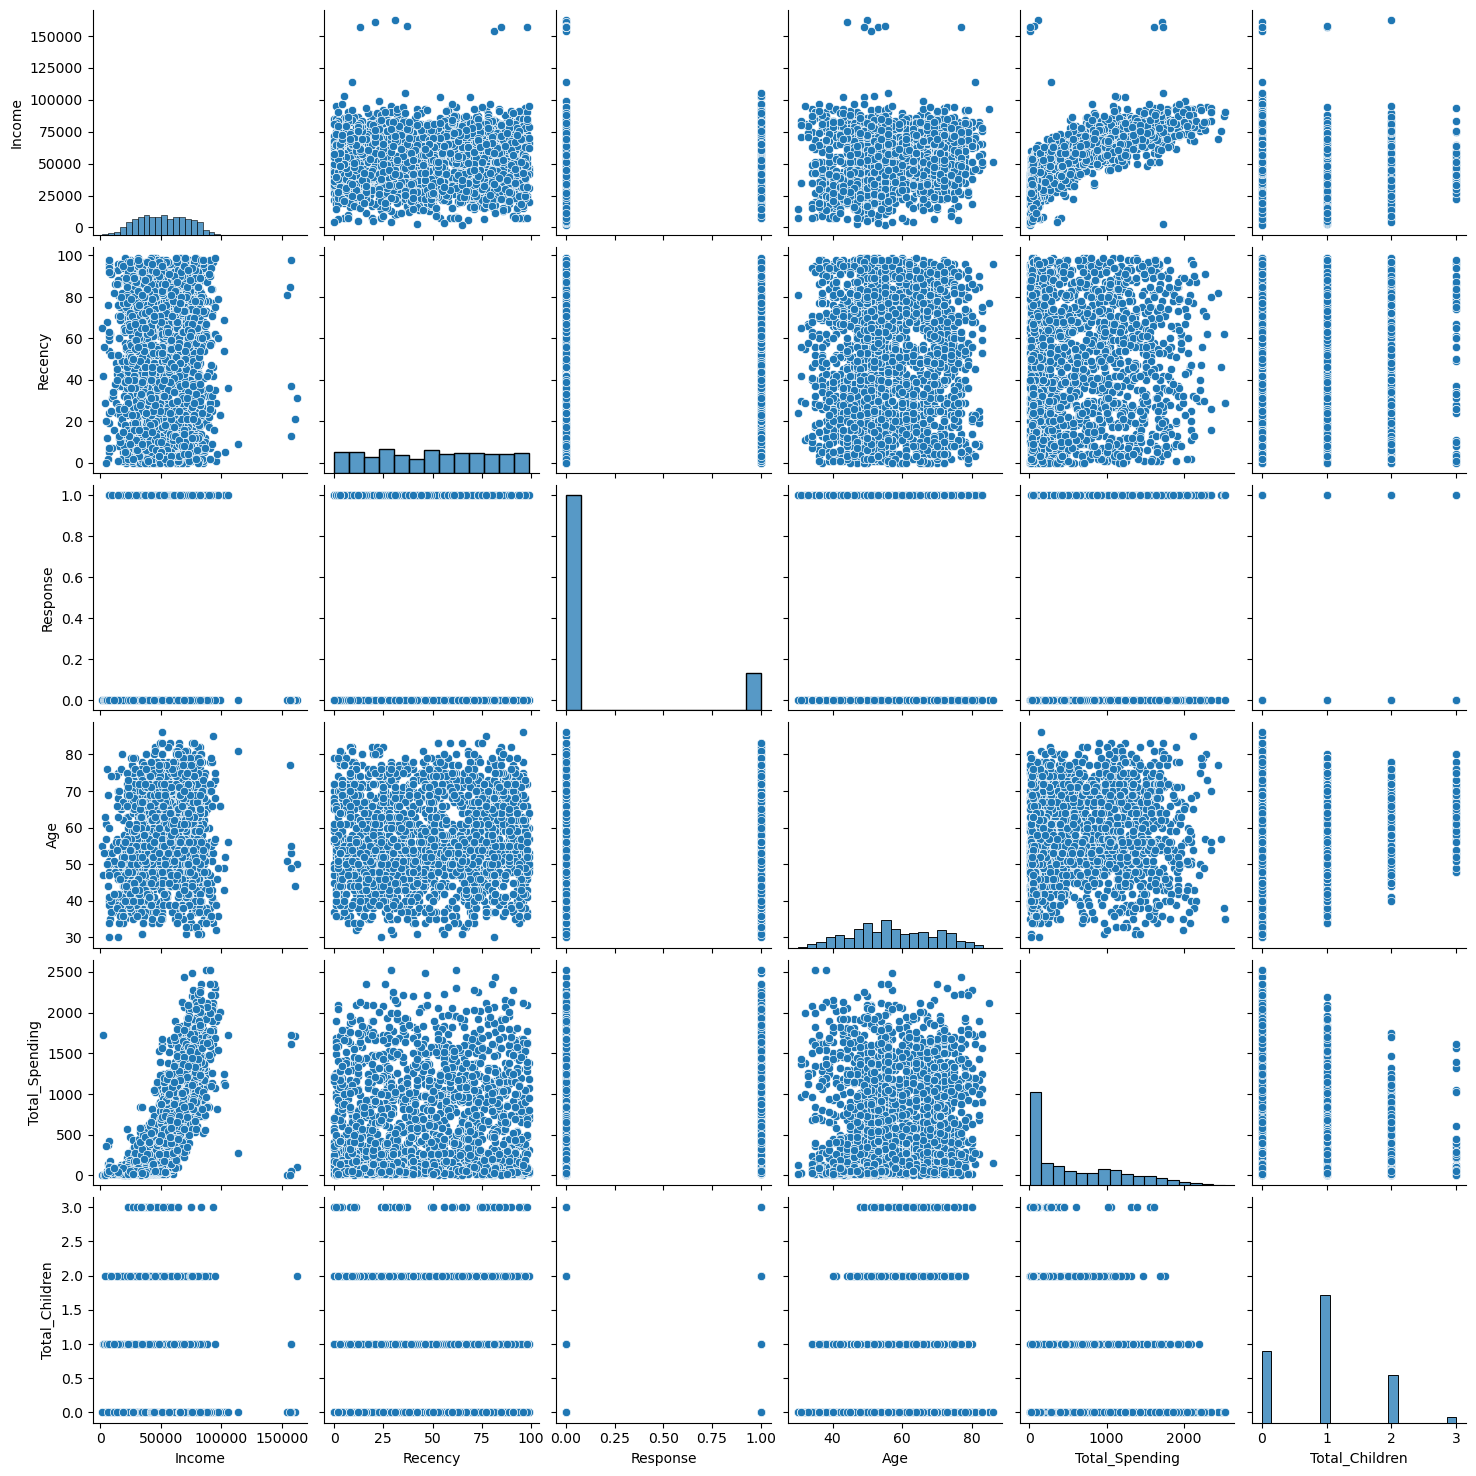

In [39]:
cols = ["Income", "Recency", "Response", "Age", "Total_Spending", "Total_Children"]

# Relative plots of some features - Pair plots 
sns.pairplot(df_cleaned[cols])

In [42]:
# Remove Outliers 
# in "Age" - 120 is an outlier so we need to remove it 
# similarly in income an outlier is present ie. > 600_000, so we need to remove them 
df_cleaned = df_cleaned[df_cleaned["Age"]<90]
df_cleaned = df_cleaned[df_cleaned["Income"]<600_000]

In [43]:
corr = df_cleaned.corr(numeric_only=True)

<Axes: >

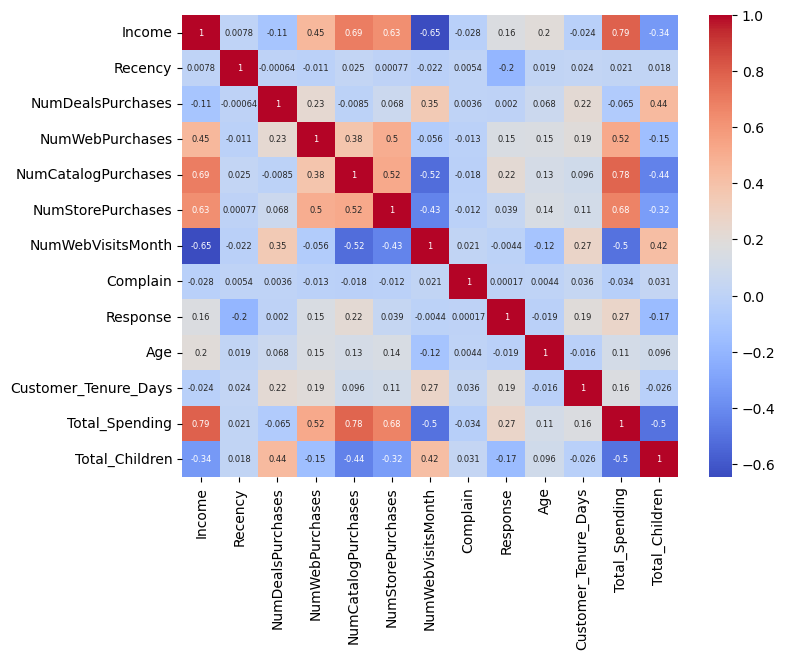

In [50]:
plt.figure(figsize = (8,6))
sns.heatmap(
    corr, 
    annot = True, 
    annot_kws = {"size":6},
    cmap = "coolwarm"
)

# Encoding

In [53]:
df_cleaned.head()

,Education,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Age,Customer_Tenure_Days,Total_Spending,Total_Children,Living_With
0,Graduate,58138.0,58,3,8,10,4,7,0,1,69,663,1617,0,Alone
1,Graduate,46344.0,38,2,1,1,2,5,0,0,72,113,27,2,Alone
2,Graduate,71613.0,26,1,8,2,10,4,0,0,61,312,776,0,Partner
3,Graduate,26646.0,26,2,2,0,4,6,0,0,42,139,53,1,Partner
4,Postgraduate,58293.0,94,5,5,3,6,5,0,0,45,161,422,1,Partner


In [52]:
from sklearn.preprocessing import OneHotEncoder

In [56]:
ohe = OneHotEncoder()

cat_cols = ["Education", "Living_With"]

enc_cols = ohe.fit_transform(df_cleaned[cat_cols])

In [58]:
enc_df = pd.DataFrame(enc_cols.toarray(), columns =ohe.get_feature_names_out(cat_cols), index = df_cleaned.index)

In [60]:
enc_df.head()

,Education_Graduate,Education_Postgraduate,Education_Undergraduate,Living_With_Alone,Living_With_Partner
0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0


In [71]:
df_encoded = pd.concat([df_cleaned.drop(columns = cat_cols), enc_df], axis = 1 )

In [72]:
df_encoded.shape

(2236, 18)

In [74]:
df_encoded.head()

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Age,Customer_Tenure_Days,Total_Spending,Total_Children,Education_Graduate,Education_Postgraduate,Education_Undergraduate,Living_With_Alone,Living_With_Partner
0,58138.0,58,3,8,10,4,7,0,1,69,663,1617,0,1.0,0.0,0.0,1.0,0.0
1,46344.0,38,2,1,1,2,5,0,0,72,113,27,2,1.0,0.0,0.0,1.0,0.0
2,71613.0,26,1,8,2,10,4,0,0,61,312,776,0,1.0,0.0,0.0,0.0,1.0
3,26646.0,26,2,2,0,4,6,0,0,42,139,53,1,1.0,0.0,0.0,0.0,1.0
4,58293.0,94,5,5,3,6,5,0,0,45,161,422,1,0.0,1.0,0.0,0.0,1.0


# Scaling

In [66]:
from sklearn.preprocessing import StandardScaler

In [75]:
X = df_encoded

In [76]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

# Visualize 

In [78]:
from sklearn.decomposition import PCA

In [84]:
pca = PCA(n_components = 3)

X_pca = pca.fit_transform(X_scaled)

In [85]:
pca.explained_variance_ratio_  

array([0.23163158, 0.11385454, 0.10405815])

Text(0.5, 0.92, '3D Projection')

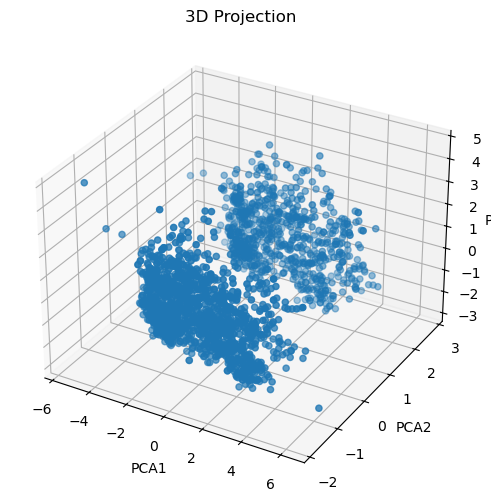

In [87]:
fig = plt.figure(figsize= (8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2])

ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")

ax.set_title("3D Projection")

In [83]:
pca.explained_variance_ratio_  # total varience captured is very low 

array([0.23163158, 0.11385451])

# Analyse K values

## 1)Elbow Methord 

In [88]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state= 42)
    kmeans.fit_predict(X_pca)
    wcss.append(kmeans.inertia_)

In [94]:
knee = KneeLocator(range(1,11), wcss, curve="convex", direction="decreasing")
optimal_k= knee.elbow

In [96]:
print("best k =",optimal_k)

best k = 4


Text(0, 0.5, 'WCSS')

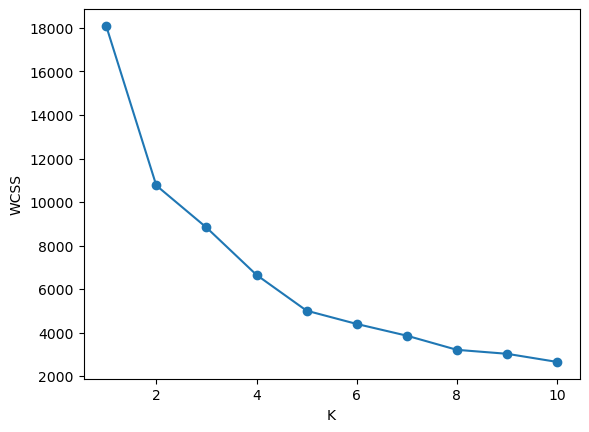

In [100]:
plt.plot(range(1,11), wcss, marker="o")
plt.xlabel("K")
plt.ylabel("WCSS")

## 2)Silhouette score 

Text(0, 0.5, 'Silhouette Score')

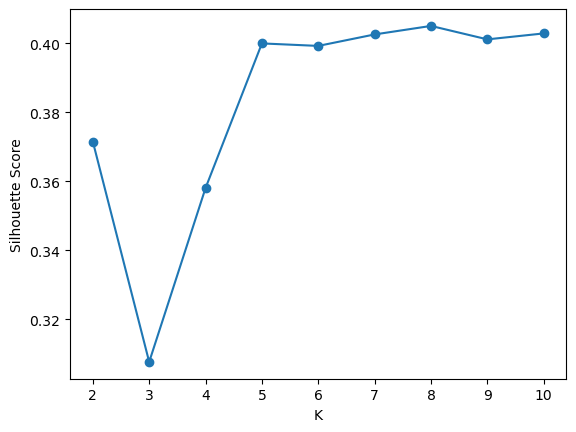

In [103]:
from sklearn.metrics import silhouette_score

scores = []

for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    scores.append(score)

plt.plot(range(2,11), scores, marker="o")
plt.xlabel("K")
plt.ylabel("Silhouette Score")

Text(0, 0.5, 'Silohuette Score')

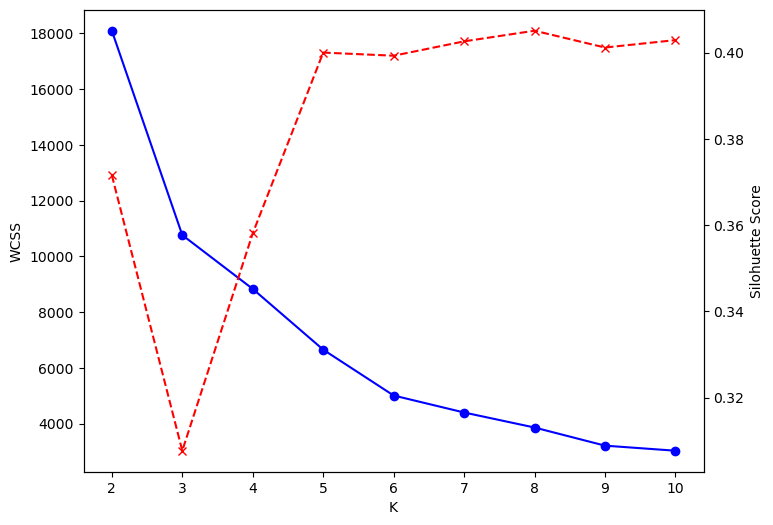

In [118]:
# conbined plot
k_range = range(2,11)

fig, ax1 = plt.subplots(figsize = (8, 6))
ax1.plot(k_range, wcss[:len(k_range)], marker ="o", color="blue")

ax1.set_xlabel("K")
ax1.set_ylabel("WCSS")

ax2 = ax1.twinx()
ax2.plot(k_range, scores[:len(k_range)], marker="x", color="red", linestyle="--")
ax2.set_ylabel("Silohuette Score")

# Clustering

In [120]:
# k means
kmeans = KMeans(n_clusters = 4 , random_state = 42)
labels_kmaens = kmeans.fit_predict(X_pca)

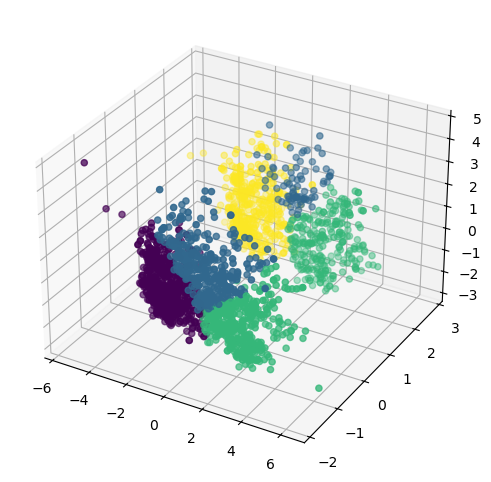

In [121]:
fig = plt.figure(figsize= (8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=labels_kmaens)

In [122]:
# Agglomerative Clustering

from sklearn.cluster import AgglomerativeClustering

In [123]:
agg_clf = AgglomerativeClustering(n_clusters=4, linkage = "ward")
labels_agg = agg_clf.fit_predict(X_pca)

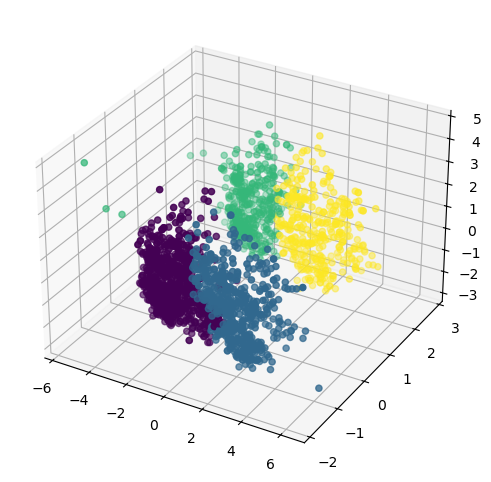

In [124]:
fig = plt.figure(figsize= (8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=labels_agg)

# Characterisation of Clusters

In [137]:
X["cluster"]= labels_agg

In [138]:
X.head()

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Age,Customer_Tenure_Days,Total_Spending,Total_Children,Education_Graduate,Education_Postgraduate,Education_Undergraduate,Living_With_Alone,Living_With_Partner,cluster
0,58138.0,58,3,8,10,4,7,0,1,69,663,1617,0,1.0,0.0,0.0,1.0,0.0,3
1,46344.0,38,2,1,1,2,5,0,0,72,113,27,2,1.0,0.0,0.0,1.0,0.0,2
2,71613.0,26,1,8,2,10,4,0,0,61,312,776,0,1.0,0.0,0.0,0.0,1.0,1
3,26646.0,26,2,2,0,4,6,0,0,42,139,53,1,1.0,0.0,0.0,0.0,1.0,0
4,58293.0,94,5,5,3,6,5,0,0,45,161,422,1,0.0,1.0,0.0,0.0,1.0,0


<Axes: xlabel='cluster', ylabel='count'>

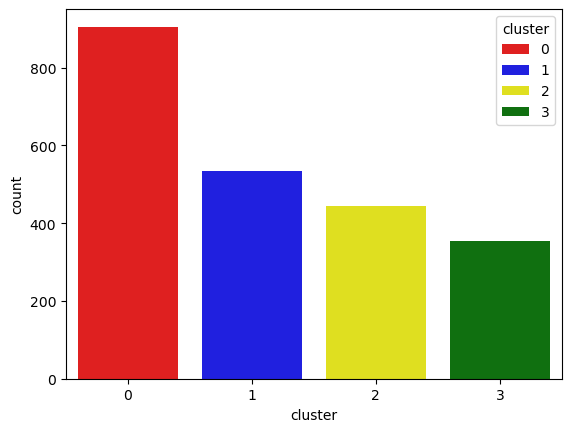

In [139]:
pal = ["red", "blue", "yellow", "green"]
sns.countplot(x=X["cluster"], palette = pal, hue=X["cluster"] )

<Axes: xlabel='Total_Spending', ylabel='Income'>

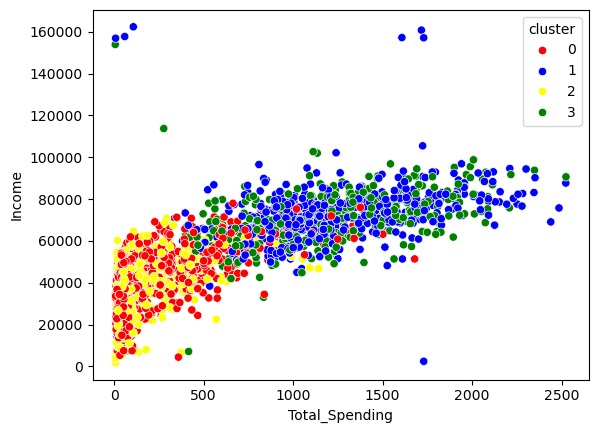

In [140]:
# Income & Spending Patterns

sns.scatterplot(x=X["Total_Spending"], y=X["Income"], hue=X["cluster"], palette= pal)

In [143]:
# Cluster Summary
cluster_summary= X.groupby("cluster").mean()
print(cluster_summary)

               Income    Recency  NumDealsPurchases  NumWebPurchases  \
cluster                                                                
0        39680.580110  48.914917           2.594475         3.153591   
1        72808.445693  49.202247           1.958801         5.687266   
2        36960.143018  48.319820           2.594595         2.713964   
3        70722.681303  50.504249           1.855524         5.790368   

         NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  Complain  \
cluster                                                                        
0                   0.969061           4.143646           6.307182  0.011050   
1                   5.498127           8.659176           3.580524  0.005618   
2                   0.837838           3.623874           6.659910  0.011261   
3                   5.014164           8.430595           3.728045  0.005666   

         Response        Age  Customer_Tenure_Days  Total_Spending  \
cluster         